In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from pymonad.tools import curry
from math import sqrt
from functools import reduce

In [2]:
# importing reduce() from functools
from functools import reduce
def compose(*funcs):
    return reduce(lambda f,g : lambda x : f(g(x)), funcs, lambda x : x)

In [3]:
# patterns : [closure,class,object]
def class_sumstats(size = None) : # sumstats class (a factory)
    wsize = size if size == None else size + 1 
    sumstats = deque([(0.0,0.0,0.0)],wsize)
    def cardinality() :
        nonlocal sumstats
        return len(sumstats) - 1 
    def domain() :
        nonlocal sumstats
        return range(len(sumstats)-1)
    def push(y) :
        nonlocal sumstats,wsize
        last = sumstats[-1]
        sumstats.append((y,last[1] + y,last[2] + y*y))
        if len(sumstats) == sumstats.maxlen :
            y0,sy0,syy0 = sumstats[0]
            sumstats = deque([(y - y0,sy - sy0,syy - syy0) for y,sy,syy in sumstats],
                             wsize)
        return value,domain,cardinality,push
    def value(i) :
        return sumstats[i]
    return value,domain,cardinality,push

In [4]:
def class_normal_mean_segment_cost(sumstats) :
    ss_value,ss_domain,ss_cardinality = sumstats
    def cardinality() :
        nonlocal ss_cardinality
        n = ss_cardinality()
        return int(n*(n+1)/2)
    def value(a,b) :
        nonlocal ss_value
        _,sya,syya = ss_value(a)
        _,syb,syyb = ss_value(b+1)
        val = syb - sya
        val *= val
        val /= (b - a + 1)
        val = -val
        val += syyb - syya
        return val
    def domain() :
        nonlocal ss_domain
        outer = ss_domain()
        for a in outer :
            inner = ss_domain()
            for b in inner :
                if b >= a :
                    yield (a,b)
    return value,domain,cardinality
        

In [5]:
def class_summed_cost(segment_cost) :
    sc_value,sc_domain,sc_cardinality = segment_cost
    def cardinality() :
        nonlocal sc_cardinality
        return int((sqrt(8*sc_cardinality()+1)-1)/2)
    def domain() :
        return range(cardinality())
    def value(i) :
        nonlocal sc_value
        b = cardinality()-1
        res = sc_value(i,b)
        if i == 0 :
            return sc_value(i,b)
        return sc_value(0,i-1) + sc_value(i,cardinality()-1)
    return value,domain,cardinality

In [6]:
np.random.seed(0)
Z = [float(z) for z in list(np.random.normal(0, 1, 1000)) + 
    list(np.random.normal(1, 1, 1000))] # +
    # list(np.random.normal(0, 1, 1000))]
cost = compose(class_summed_cost,class_normal_mean_segment_cost)
value,domain,cardinality,push = class_sumstats(2000)
value,domain,cardinality = cost((value,domain,cardinality))
for z in Z : push(z)

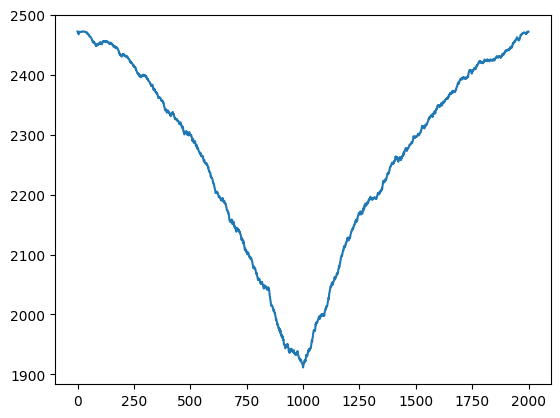

In [7]:
Y = [value(x) for x in domain()]
plt.plot(Y)